In [1]:
import numpy  as np
import seaborn as sns
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

从mask后的数据计算每月的情况，将13年的4-8月绘制热图比较<br>

此处简单地做了个减法

remains:绘制更多统计量的

In [2]:
# 读取数据
# year = "2006"
# 注释掉的是原始数据，此后的是进行了mask之后的数据
# dir_vr = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/pre/" + "daily_pre_03-15.nc"
dir_vr = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" + "mask_vr_pre_03-15.nc"
ds_vr = xr.open_dataset(dir_vr)
# ds_vr

# dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_03-15.nc"
dir_rcm = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" + "mask_rcm_pre_03-15.nc"
ds_rcm = xr.open_dataset(dir_rcm)
# ds_rcm

# obs_cmorph = "/raid52/yycheng/MPAS/REFERENCE/CMORPH/DAILY/cdo_merge_daily/*.nc"
# ds_cmorph = xr.open_mfdataset(obs_cmorph, combine='by_coords',concat_dim='time')
obs_cmorph = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" + "mask_sel_CMORPH_03-15.nc"
ds_cmorph = xr.open_dataset(obs_cmorph)

obs_cn051  = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_pre/mask_res/" +  "mask_sel_CN05.1_Pre_1961_2018_daily_025x025.nc"
ds_cn051 = xr.open_dataset(obs_cn051)

ds_cn051_time_loc_year = (ds_cn051.time.dt.year >= 2003) & (ds_cn051.time.dt.year <= 2015)
ds_cn051_time_loc_month= (ds_cn051.time.dt.month>=    4) & (ds_cn051.time.dt.month <= 8)
ds_cn051_sel = ds_cn051.isel(time = ds_cn051_time_loc_year & ds_cn051_time_loc_month)

# ds_cmorph
# precip_obs = ds_disk["precip_CMORPH"]
# precip_mod = ds_disk["precip_MPAS"]
vr_mean     = ds_vr['precip_MPAS'].mean(dim=["longitude","latitude"])
rcm_mean    = ds_rcm['precip_MPAS'].mean(dim=["longitude","latitude"])
cmorph_mean = ds_cmorph['cmorph'].mean(dim=["lon","lat","lev"]) # remove single dimension
cn051_mean  = ds_cn051_sel['pre'].mean(dim=['lon','lat'])


/m2data2/yycheng/anaconda3/envs/pync/lib/python3.9/site-packages/xarray/coding/times.py:113: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [9]:
type(ds_cn051['pre'].values)

numpy.ndarray

计算月平均

In [4]:
# rename coordinates
vr_mean = vr_mean.rename({"Time":"time"})
rcm_mean = rcm_mean.rename({"Time":"time"})

In [5]:
cn051_monmean_temp = cn051_mean.resample(time="1MS").mean().dropna(dim='time')
cn051_monmean      = dict(cn051_monmean_temp.groupby(cn051_monmean_temp.time.dt.year))

vr_monmean_temp = vr_mean.resample(time="1MS").mean().dropna(dim='time')
vr_monmean      = dict(vr_monmean_temp.groupby(vr_monmean_temp.time.dt.year))

rcm_monmean_temp = rcm_mean.resample(time="1MS").mean().dropna(dim='time')
rcm_monmean      = dict(rcm_monmean_temp.groupby(rcm_monmean_temp.time.dt.year))

In [7]:
timeseries03_15 = pd.date_range("2003","2015",freq="AS")
timeseries03_15
cn051_pd.columns = timeseries03_15

In [8]:
cn051_pd = pd.DataFrame(cn051_monmean)
cn051_pd.index = ['Apr','May','Jun','Jul','Aug']
# cn051_pd
cn051_pd.columns = timeseries03_15

vr_pd = pd.DataFrame(vr_monmean)
vr_pd.index = ['Apr','May','Jun','Jul','Aug']
# vr_pd
vr_pd.columns = timeseries03_15

rcm_pd = pd.DataFrame(rcm_monmean)
rcm_pd.index = ['Apr','May','Jun','Jul','Aug']
# rcm_pd
rcm_pd.columns = timeseries03_15

In [17]:
# add VR>RCM
compared = abs(vr_pd) - abs(rcm_pd)

In [13]:
compared

,2003-01-01 00:00:00,2004-01-01 00:00:00,2005-01-01 00:00:00,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,2009-01-01 00:00:00,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00
Apr,True,True,True,True,True,False,True,False,True,False,False,True,True
May,True,False,False,False,True,True,True,False,False,True,False,False,False
Jun,False,True,False,False,False,False,False,False,False,False,False,False,False
Jul,False,False,False,False,False,False,True,False,False,False,True,False,True
Aug,False,True,False,True,False,False,True,True,True,False,True,False,True


绘图，使用seaborn的绘图版绘制<br>
打算使用的 matplotlib.dates 不能正常工作，手工添加坐标

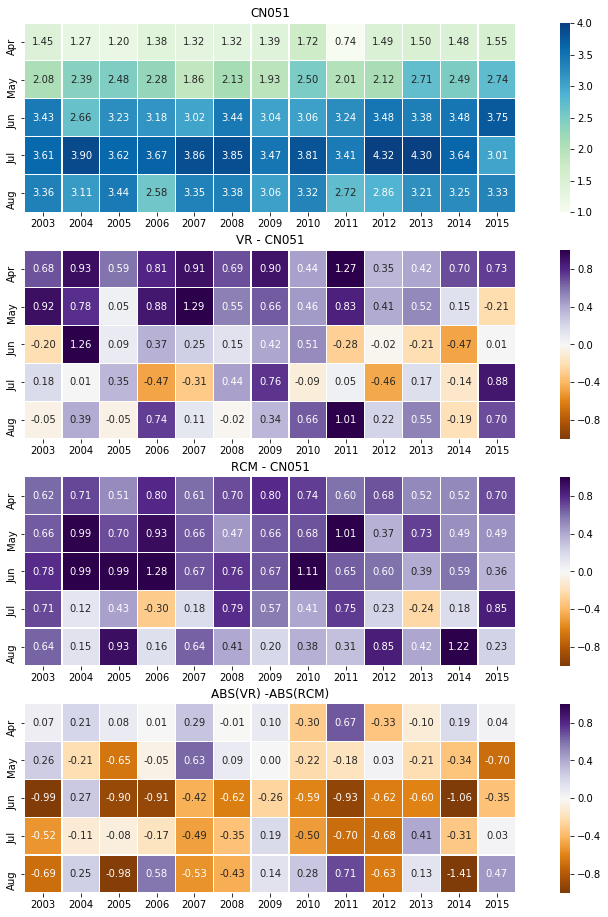

In [19]:
import seaborn as sns
import matplotlib.dates as mdates
import datetime
import matplotlib.colors as mcolors
# plt.figure(figsize=(14,4))
fig,ax = plt.subplots(4,1,figsize=(16,16))

# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%y')

# 重新映射颜色，但其实影响不大
norm = mcolors.Normalize(vmin=1, vmax=4)

sns.heatmap(cn051_pd, ax = ax[0], vmin=1,vmax=4 ,fmt = ".2f", square= True, xticklabels = 1,linewidths=.2, cmap="GnBu",
annot=True)
sns.heatmap(vr_pd - cn051_pd,ax = ax[1], vmin = -1, vmax = 1 ,fmt = ".2f", square= True, xticklabels = 1,linewidths=.2, cmap="PuOr", 
annot=True)
sns.heatmap(rcm_pd - cn051_pd,ax = ax[2], vmin = -1, vmax = 1 ,fmt = ".2f", square= True, xticklabels = 1,linewidths=.2, cmap="PuOr", 
annot=True)
sns.heatmap(compared,ax = ax[3], vmin = -1, vmax = 1 ,fmt = ".2f", square= True, xticklabels = 1,linewidths=.2, cmap="PuOr", 
annot=True)
# ax.xticks(rotation=0)
ax[0].set_title("CN051")
ax[1].set_title("VR - CN051")
ax[2].set_title("RCM - CN051")
ax[3].set_title("ABS(VR) -ABS(RCM)")

xticks = pd.date_range(datetime.datetime(2003,1,1), datetime.datetime(2015,1,1), freq='ys')
for i in ax:
    i.set_xticklabels([x.strftime('%Y') for x in xticks]); 
    # rotated every ticks
    for tick in i.get_xticklabels():
        tick.set_rotation(0)

# does not work
# ax[2].xaxis.set_major_locator(years)
# ax[2].xaxis.set_major_formatter(years_fmt)
# ax[0].xaxis.set_major_formatter(dates.DateFormatter('%YY'))


# fig.title("2003-2015")
plt.savefig("./output_pic/heatplot_months_stats.png")